# Networks Using Blocks (VGG)
:label:`sec_vgg`

While AlexNet offered empirical evidence that deep CNNs
can achieve good results, it did not provide a general template
to guide subsequent researchers in designing new networks.
In the following sections, we will introduce several heuristic concepts
commonly used to design deep networks.

Progress in this field mirrors that of VLSI (very large scale integration) 
in chip design
where engineers moved from placing transistors
to logical elements to logic blocks :cite:`Mead.1980`.
Similarly, the design of neural network architectures
has grown progressively more abstract,
with researchers moving from thinking in terms of
individual neurons to whole layers,
and now to blocks, repeating patterns of layers. A decade later, this has now
progressed to researchers using entire trained models to repurpose them for different, 
albeit related, tasks. Such large pretrained models are typically called 
*foundation models* :cite:`bommasani2021opportunities`. 

Back to network design. The idea of using blocks first emerged from the
Visual Geometry Group (VGG) at Oxford University,
in their eponymously-named *VGG* network :cite:`Simonyan.Zisserman.2014`.
It is easy to implement these repeated structures in code
with any modern deep learning framework by using loops and subroutines.



# 使用块结构的网络（VGG）
:label:`sec_vgg`

尽管AlexNet提供了经验性证据证明深度卷积神经网络能取得优异结果，但并未提供一个通用模板来指导后续研究者设计新的网络。在下面的章节中，我们将介绍几种常用于设计深度网络的启发式概念。

这一领域的进展与芯片设计中VLSI（超大规模集成电路）的发展相呼应，工程师们从放置晶体管到逻辑元件再到逻辑块:cite:`Mead.1980`。类似地，神经网络架构的设计逐渐变得更加抽象，研究者从单个神经元的角度思考过渡到整个层，现在又转向由层重复模式组成的块结构。十年后，这一趋势已发展为研究者直接使用整个训练好的模型作为基础，将其复用于不同但相关的任务。这类大规模预训练模型通常被称为*基础模型*:cite:`bommasani2021opportunities`。

回到网络设计。使用块结构的想法首先出现在牛津大学的Visual Geometry Group（VGG）提出的*VGG*网络中:cite:`Simonyan.Zisserman.2014`。通过使用循环和子程序，可以很容易地在任何现代深度学习框架的代码中实现这些重复结构。


In [2]:
import torch
from torch import nn
from d2l import torch as d2l

## (**VGG Blocks**)
:label:`subsec_vgg-blocks`

The basic building block of CNNs
is a sequence of the following:
(i) a convolutional layer
with padding to maintain the resolution,
(ii) a nonlinearity such as a ReLU,
(iii) a pooling layer such
as max-pooling to reduce the resolution. One of the problems with 
this approach is that the spatial resolution decreases quite rapidly. In particular, 
this imposes a hard limit of $\log_2 d$ convolutional layers on the network before all 
dimensions ($d$) are used up. For instance, in the case of ImageNet, it would be impossible to have 
more than 8 convolutional layers in this way. 

The key idea of :citet:`Simonyan.Zisserman.2014` was to use *multiple* convolutions in between downsampling
via max-pooling in the form of a block. They were primarily interested in whether deep or 
wide networks perform better. For instance, the successive application of two $3 \times 3$ convolutions
touches the same pixels as a single $5 \times 5$ convolution does. At the same time, the latter uses approximately 
as many parameters ($25 \cdot c^2$) as three $3 \times 3$ convolutions do ($3 \cdot 9 \cdot c^2$). 
In a rather detailed analysis they showed that deep and narrow networks significantly outperform their shallow counterparts. This set deep learning on a quest for ever deeper networks with over 100 layers for typical applications.
Stacking $3 \times 3$ convolutions
has become a gold standard in later deep networks (a design decision only to be revisited recently by 
:citet:`liu2022convnet`). Consequently, fast implementations for small convolutions have become a staple on GPUs :cite:`lavin2016fast`. 

Back to VGG: a VGG block consists of a *sequence* of convolutions with $3\times3$ kernels with padding of 1 
(keeping height and width) followed by a $2 \times 2$ max-pooling layer with stride of 2
(halving height and width after each block).
In the code below, we define a function called `vgg_block`
to implement one VGG block.

The function below takes two arguments,
corresponding to the number of convolutional layers `num_convs`
and the number of output channels `num_channels`.


## [**VGG块**]
:label:`subsec_vgg-blocks`

卷积神经网络的基本构建块由以下序列组成：
(i) 带填充保持分辨率的卷积层
(ii) 非线性激活函数（如ReLU）
(iii) 池化层（如最大池化层）用于降低分辨率。
这种方法存在的一个问题是空间分辨率下降得相当快。特别是，这给网络施加了一个硬性限制：在使用所有维度（$d$）之前，最多只能有$\log_2 d$个卷积层。例如，在ImageNet案例中，使用这种方法将无法超过8个卷积层。

:citet:`Simonyan.Zisserman.2014`的关键思想是在通过最大池化进行下采样之间使用*多个*卷积层形成块结构。他们主要研究深层网络与宽层网络哪种表现更好。例如，连续应用两个$3 \times 3$卷积层与单个$5 \times 5$卷积层的感受野相同，但后者使用的参数量（$25 \cdot c^2$）大约是前者（$3 \cdot 9 \cdot c^2$）的三倍。

通过详细分析，他们证明了深层窄网络明显优于浅层宽网络。这开启了深度学习追求更深网络的潮流，典型应用中的网络深度超过100层。堆叠$3 \times 3$卷积层已成为后续深度网络的金标准（这一设计选择直到最近才被:citet:`liu2022convnet`重新审视）。因此，针对小卷积核的快速实现已成为GPU上的标配:cite:`lavin2016fast`。

回到VGG：一个VGG块由多个$3\times3$卷积核（保持高宽不变的padding=1）组成的*序列*，后接一个步幅为2的$2 \times 2$最大池化层（每个块后高宽减半）。下面的代码中，我们定义了一个`vgg_block`函数来实现一个VGG块。

该函数接收两个参数：卷积层数量`num_convs`和输出通道数`num_channels`。

In [1]:
def vgg_block(num_convs, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.LazyConv2d(out_channels, kernel_size=3, padding=1))
        layers.append(nn.ReLU())
    layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
    return nn.Sequential(*layers)

In [3]:
def my_vgg_block(num_convs, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.LazyConv2d(out_channels, kernel_size=3, padding=1))
        layers.append(nn.ReLU())
    layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
    return nn.Sequential(*layers)

## [**VGG Network**]
:label:`subsec_vgg-network`

Like AlexNet and LeNet, 
the VGG Network can be partitioned into two parts:
the first consisting mostly of convolutional and pooling layers
and the second consisting of fully connected layers that are identical to those in AlexNet. 
The key difference is 
that the convolutional layers are grouped in nonlinear transformations that 
leave the dimensonality unchanged, followed by a resolution-reduction step, as 
depicted in :numref:`fig_vgg`. 

![From AlexNet to VGG. The key difference is that VGG consists of blocks of layers, whereas AlexNet's layers are all designed individually.](../img/vgg.svg)
:width:`400px`
:label:`fig_vgg`

The convolutional part of the network connects several VGG blocks from :numref:`fig_vgg` (also defined in the `vgg_block` function)
in succession. This grouping of convolutions is a pattern that has 
remained almost unchanged over the past decade, although the specific choice of 
operations has undergone considerable modifications. 
The variable `arch` consists of a list of tuples (one per block),
where each contains two values: the number of convolutional layers
and the number of output channels,
which are precisely the arguments required to call
the `vgg_block` function. As such, VGG defines a *family* of networks rather than just 
a specific manifestation. To build a specific network we simply iterate over `arch` to compose the blocks.


## [**VGG网络**]
:label:`subsec_vgg-network`

与AlexNet和LeNet类似，VGG网络可分为两个部分：
第一部分主要由卷积层和汇聚层组成，
第二部分由与AlexNet完全相同的全连接层构成。
关键区别在于
VGG的卷积层被组织成保持维度不变的非线性变换模块，
后接分辨率缩减步骤，
如 :numref:`fig_vgg` 所示。

![从AlexNet到VGG。关键区别在于VGG由层块构成，而AlexNet的层都是独立设计的](../img/vgg.svg)
:width:`400px`
:label:`fig_vgg`

网络的卷积部分通过连续堆叠 :numref:`fig_vgg` 中定义的VGG块（由`vgg_block`函数实现）来构建。这种卷积模块化的设计模式在过去十年中几乎保持不变，尽管具体操作选择经历了重大改进。

变量`arch`由元组列表组成（每个块对应一个元组），
每个元组包含两个值：卷积层数量
和输出通道数，
这正是调用`vgg_block`函数所需的参数。
因此，VGG定义了一个网络*家族*，
而非单一的具体实现。要构建具体网络，
我们只需遍历`arch`来堆叠各个块。

In [5]:
class VGG(d2l.Classifier):
    def __init__(self, arch, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        conv_blks = []
        for (num_convs, out_channels) in arch:
            conv_blks.append(vgg_block(num_convs, out_channels))
        self.net = nn.Sequential(
            *conv_blks, nn.Flatten(),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(0.5),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(0.5),
            nn.LazyLinear(num_classes))
        self.net.apply(d2l.init_cnn)

In [9]:
class ChiVGG(d2l.Classifier):
    def __init__(self, arch, lr=0.01, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        conv_blks = []
        for num_convs, out_channels in arch:
            conv_blks.append(my_vgg_block(num_convs, out_channels))
        self.net = nn.Sequential(
            *conv_blks,
            nn.Flatten(),
            nn.LazyLinear(4096),nn.ReLU(),nn.Dropout(0.5),
            nn.LazyLinear(4096),nn.ReLU(),nn.Dropout(0.5),
            nn.LazyLinear(num_classes)
        )
        self.net.apply(d2l.init_cnn)
        

The original VGG network had five convolutional blocks,
among which the first two have one convolutional layer each
and the latter three contain two convolutional layers each.
The first block has 64 output channels
and each subsequent block doubles the number of output channels,
until that number reaches 512.
Since this network uses eight convolutional layers
and three fully connected layers, it is often called VGG-11.

原始VGG网络包含五个卷积块，其中前两个块各有一个卷积层，后三个块各有两个卷积层。第一个块的输出通道数为64，每个后续块将输出通道数翻倍，直至达到512。由于该网络使用八个卷积层和三个全连接层，因此通常被称为VGG-11。



In [10]:
VGG(arch=((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))).layer_summary(
    (1, 1, 224, 224))

Sequential output shape:	 torch.Size([1, 64, 112, 112])
Sequential output shape:	 torch.Size([1, 128, 56, 56])
Sequential output shape:	 torch.Size([1, 256, 28, 28])
Sequential output shape:	 torch.Size([1, 512, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
Flatten output shape:	 torch.Size([1, 25088])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 10])


In [11]:
ChiVGG(arch=((1,64),(1,128),(2,256),(2,512),(2,512))).layer_summary(
    (1,1,224,224)
)

Sequential output shape:	 torch.Size([1, 64, 112, 112])
Sequential output shape:	 torch.Size([1, 128, 56, 56])
Sequential output shape:	 torch.Size([1, 256, 28, 28])
Sequential output shape:	 torch.Size([1, 512, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
Flatten output shape:	 torch.Size([1, 25088])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 10])


As you can see, we halve height and width at each block,
finally reaching a height and width of 7
before flattening the representations
for processing by the fully connected part of the network. 
:citet:`Simonyan.Zisserman.2014` described several other variants of VGG. 
In fact, it has become the norm to propose *families* of networks with 
different speed--accuracy trade-off when introducing a new architecture. 

## Training

[**Since VGG-11 is computationally more demanding than AlexNet
we construct a network with a smaller number of channels.**]
This is more than sufficient for training on Fashion-MNIST.
The [**model training**] process is similar to that of AlexNet in :numref:`sec_alexnet`. 
Again observe the close match between validation and training loss, 
suggesting only a small amount of overfitting.

如我们所见，每个块都会将高度和宽度减半，
最终在展平表示进行全连接处理前，
特征图的高宽会缩减到7。
:citet:`Simonyan.Zisserman.2014`描述了VGG的其他几种变体。
实际上，现今提出新架构时同时发布不同速度-精度权衡的*网络家族*已成为行业惯例。

## 训练

[**由于VGG-11比AlexNet计算需求更高，我们构建了通道数较少的网络**]
这对Fashion-MNIST数据集训练已完全足够。
[**模型训练**]过程与AlexNet类似（参见 :numref:`sec_alexnet`）。
再次观察到验证损失与训练损失高度吻合，
表明过拟合程度非常有限。


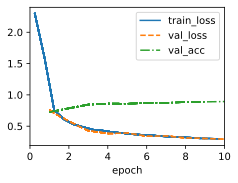

In [12]:
model = VGG(arch=((1, 16), (1, 32), (2, 64), (2, 128), (2, 128)), lr=0.01)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(224, 224))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

In [ ]:
chi_model = ChiVGG(arch=((1,16),(1,32),(2,64),(2,128),(2,128)), lr=0.01)
chi_trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
chi_data = d2l.FashionMNIST(batch_size=128, resize=(224,224))
chi_model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
chi_trainer.fit(chi_model, chi_data)

## Summary

One might argue that VGG is the first truly modern convolutional neural network. While AlexNet introduced many of the components of what make deep learning effective at scale, it is VGG that arguably introduced key properties such as blocks of multiple convolutions and a preference for deep and narrow networks. It is also the first network that is actually an entire family of similarly parametrized models, giving the practitioner ample trade-off between complexity and speed. This is also the place where modern deep learning frameworks shine. It is no longer necessary to generate XML configuration files to specify a network but rather, to assemble said networks through simple Python code. 

More recently ParNet :cite:`Goyal.Bochkovskiy.Deng.ea.2021` demonstrated that it is possible to achieve competitive performance using a much more shallow architecture through a large number of parallel computations. This is an exciting development and there is hope that it will influence architecture designs in the future. For the remainder of the chapter, though, we will follow the path of scientific progress over the past decade. 

## Exercises


1. Compared with AlexNet, VGG is much slower in terms of computation, and it also needs more GPU memory. 
    1. Compare the number of parameters needed for AlexNet and VGG.
    1. Compare the number of floating point operations used in the convolutional layers and in the fully connected layers. 
    1. How could you reduce the computational cost created by the fully connected layers?
1. When displaying the dimensions associated with the various layers of the network, we only see the information associated with eight blocks (plus some auxiliary transforms), even though the network has 11 layers. Where did the remaining three layers go?
1. Use Table 1 in the VGG paper :cite:`Simonyan.Zisserman.2014` to construct other common models, such as VGG-16 or VGG-19.
1. Upsampling the resolution in Fashion-MNIST eight-fold from $28 \times 28$ to $224 \times 224$ dimensions is very wasteful. Try modifying the network architecture and resolution conversion, e.g., to 56 or to 84 dimensions for its input instead. Can you do so without reducing the accuracy of the network? Consult the VGG paper :cite:`Simonyan.Zisserman.2014` for ideas on adding more nonlinearities prior to downsampling.


[Discussions](https://discuss.d2l.ai/t/78)


## 小结

可以说VGG是第一个真正意义上的现代卷积神经网络。虽然AlexNet引入了许多使大规模深度学习有效的组件，但VGG凭借其引入多个卷积组成的块结构和偏好深层窄网络的设计理念更具里程碑意义。它也是首个真正形成参数化模型家族的神经网络，为实践者提供了复杂度与速度间的充分权衡。这也正是现代深度学习框架的优势所在——不再需要生成XML配置文件来定义网络，而是通过简单的Python代码即可组装所需网络。

最近ParNet :cite:`Goyal.Bochkovskiy.Deng.ea.2021`证明通过大量并行计算，使用更浅的网络架构也能获得有竞争力的性能。这是令人振奋的进展，有望影响未来的架构设计。不过在后续章节中，我们仍将遵循过去十年的科学发展路径。

## 练习题

1. 与AlexNet相比，VGG计算速度更慢且需要更多GPU内存
    1. 比较AlexNet和VGG的参数数量
    1. 比较卷积层和全连接层的浮点运算量
    1. 如何降低全连接层产生的计算开销？
1. 当显示网络各层维度信息时，我们只看到八个块的信息（含辅助变换层），但网络实际有11层，其余三层去向如何？
1. 使用VGG论文:cite:`Simonyan.Zisserman.2014`中的表1构建其他常见模型，如VGG-16或VGG-19
1. 将Fashion-MNIST的分辨率从$28 \times 28$上采样八倍至$224 \times 224$非常低效。尝试修改网络架构和分辨率转换（如改为56或84），能否在不降低精度的情况下实现？参考VGG论文:cite:`Simonyan.Zisserman.2014`中关于下采样前增加非线性层的思路
